In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
T = 144
step=1
time = np.arange(0, T, step)
values = np.random.randn(int(T/step))*100
noise = np.random.randn(int(T/step))*1

big_event = np.zeros(int(T/step))
big_event[10:20] = np.arange(10)*100

In [3]:
def plot_time_series(time, values, label):
    plt.figure(figsize=(10,6))
    plt.plot(time, values)
    plt.xlabel("Time", fontsize=20)
    plt.ylabel("Value", fontsize=20)
    plt.title(label, fontsize=20)
    plt.grid(True)

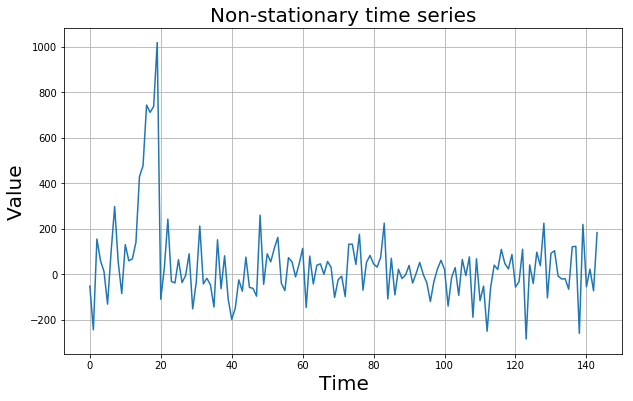

In [114]:
non_stationary = values + big_event
plot_time_series(time, non_stationary, label='Non-stationary time series')

In [13]:
np.random.uniform(5)

4.583085687958951

In [12]:
def get_data(nb_series, max_events, max_event_length, max_intensity, base, T):
    series = []
    for i in range(nb_series):
        values = np.random.randn(int(T))*base
        values = abs(values)
        nb_events = np.random.randint(max_events)
        for ev in range(nb_events):
            length = np.random.randint(max_event_length)
            last_valid_start = T - max_event_length
            start = np.random.randint(int(T))
            end = start + length
            event = np.zeros(int(T))
            event[start:end] = values[np.arange(end-start)]*max_intensity
            values += event
        series.append(values)
    return series

In [53]:
end = 30
start = 28

np.arange(end-start)
values
values[np.arange(end-start)]

array([ -52.80263667, -245.12804396])

In [14]:
nb_pain = 42
nb_nopain = 58

base = 10

pain = get_data(nb_pain, max_events=12, max_event_length=2, max_intensity=10, base=base, T=144)

nopain = get_data(nb_nopain, max_events=5, max_event_length=2, max_intensity=3, base=base, T=144)


In [60]:
pain[0].shape

(144,)

In [5]:
def plot_many_time_series(time, values, label):
    plt.figure(figsize=(10,6))
    for v in values:
        plt.plot(time, v)
    plt.xlabel("Time", fontsize=20)
    plt.ylabel("Pain expression", fontsize=20)
    plt.title(label, fontsize=20)
    plt.grid(True)

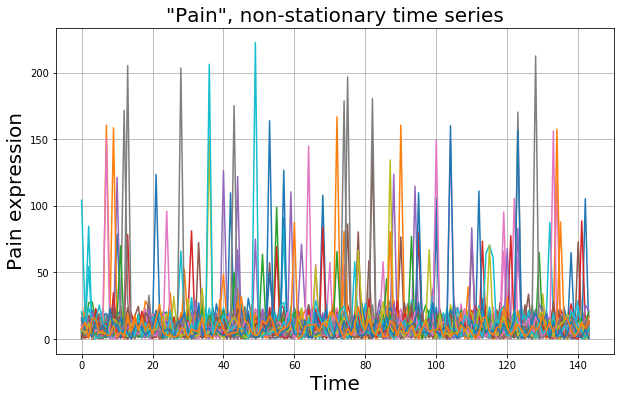

In [121]:
plot_many_time_series(time, pain, label='"Pain", non-stationary time series')

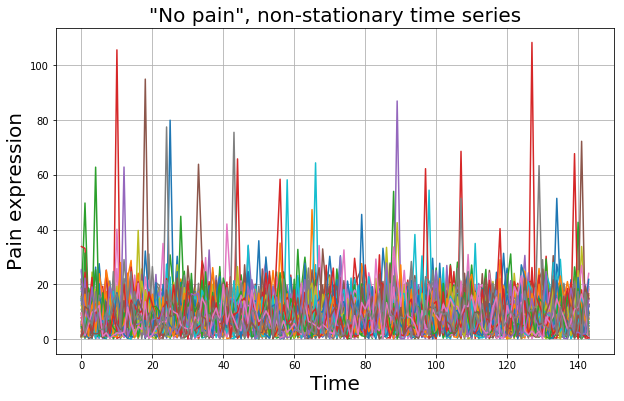

In [122]:
plot_many_time_series(time, nopain, label='"No pain", non-stationary time series')

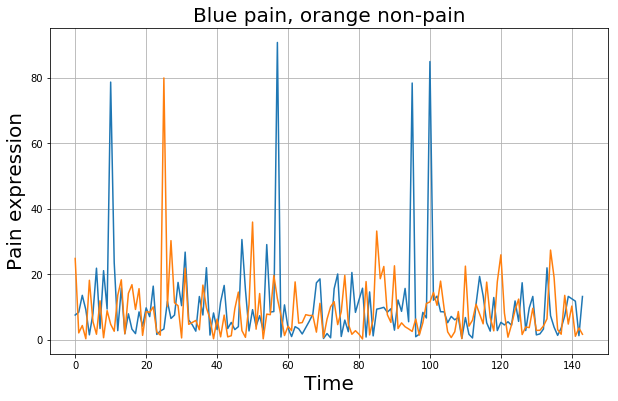

In [128]:
plot_many_time_series(time, [pain[0], nopain[0]], label='Blue pain, orange non-pain')

In [66]:
pain[0].shape

(144,)

In [67]:
nopain[0].shape

(144,)

In [70]:
data = pain + nopain

In [71]:
len(data)

100

In [75]:
labels = [np.zeros(42).tolist() + np.ones(58).tolist()]

In [80]:
labels[0][:3]

[0.0, 0.0, 0.0]

In [85]:
data[0][:3]

array([ 7.47905966,  8.35700889, 13.50528935])

In [87]:
data = [x.astype(np.float32) for x in data]

In [81]:
labels = [int(x) for x in labels[0]]

In [3]:
def gen(nb_samples, data, labels):
    data = [x.astype(np.float32) for x in data]
    labels = [int(x) for x in labels[0]]
    for i in range(nb_samples):
        x = data[i]
        label = labels[i]
        if label == 0:
            label = [1, 0]
        if label == 1:
            label = [0, 1]
        yield x, label

In [16]:
def construct_dataset(nb_pain, nb_nopain, T, base_level,
                      max_intensity_pain, max_intensity_nopain,
                      max_length_pain, max_length_nopain,
                      nb_events_pain, nb_events_nopain, batch_size):

    pain = get_data(nb_pain, max_events=nb_events_pain, max_event_length=max_length_pain,
                    max_intensity=max_intensity_pain, base=base_level, T=T)
    nopain = get_data(nb_nopain, max_events=nb_events_nopain, max_event_length=max_length_nopain,
                      max_intensity=max_intensity_nopain, base=base_level, T=T)
    data = nopain + pain
    labels = [np.zeros(nb_nopain).tolist() + np.ones(nb_pain).tolist()]
    dataset = tf.data.Dataset.from_generator(lambda: gen(nb_pain+nb_nopain, data, labels), output_types=(tf.float32,tf.int32))
    dataset = dataset.shuffle(1000, reshuffle_each_iteration=True)
    dataset = dataset.batch(batch_size)
    return dataset

In [136]:
np.random.randint(50,80)

61

In [19]:
import sys
sys.path.append('..')

def get_sparse_pain_loss(y_batch, preds_batch):
    batch_size = y_batch.shape[0]  # last batch may be smaller

    def get_mil_loss(kmax_scores):
        kmax_distribution = tf.keras.layers.Activation('softmax')(kmax_scores)
        mils = 0
        for sample_index in range(batch_size):
            label_index = tf.argmax(y_batch[sample_index, :])  # Take first (video-level label)
            mil = tf.math.log(kmax_distribution[sample_index, label_index])
            mils += mil
        return mils

    kmax_scores = get_k_max_scores_per_class(y_batch, preds_batch, batch_size)
    mil = get_mil_loss(kmax_scores)
    batch_indicator_nopain = tf.cast(y_batch[:, 0], dtype=tf.float32)
    batch_indicator_pain = tf.cast(y_batch[:, 1], dtype=tf.float32)
    tv_nopain = config_dict['tv_weight_nopain'] * tf.reduce_sum(
        batch_indicator_nopain * batch_calc_TV_norm(preds_batch[:, 0],
                                                    y_batch))
    tv_pain = config_dict['tv_weight_pain'] * tf.reduce_sum(
        batch_indicator_pain * batch_calc_TV_norm(preds_batch[:, 1],
                                                  y_batch))
    total_loss = tv_nopain + tv_pain - mil
                                                                                                                                                        
    return total_loss, tv_pain, tv_nopain, mil

def get_k_max_scores_per_class(y_batch, preds_batch, batch_size):                                                           
    kmax_scores = []
    for sample_index in range(batch_size):
        sample_class_kmax_scores = []
        seq_length = 144
        k = tf.cast(tf.math.ceil(config_dict['k_mil_fraction'] * tf.cast(seq_length, dtype=tf.float32)), dtype=tf.int32)
        # print('\n', k, seq_length)
        for class_index in range(config_dict['nb_labels']):
            preds_nopad = preds_batch[sample_index, :, class_index]
            k_preds, indices = tf.math.top_k(preds_nopad, k)
            sample_class_kmax_score = tf.cast(1/k, dtype=tf.float32) * tf.reduce_sum(k_preds)
            sample_class_kmax_scores.append(sample_class_kmax_score)
        kmax_scores.append(sample_class_kmax_scores)
    kmax_scores = tf.convert_to_tensor(kmax_scores)
    return kmax_scores


def batch_calc_TV_norm(batch_vectors, y_batch, p=3, q=3):
    """"
    Calculates the Total Variational Norm by summing the differences of the values
    in between the different positions in the mask.
    p=3 and q=3 are defaults from the paper.
    """
    val = tf.cast(0, dtype=tf.float32)
    batch_size = batch_vectors.shape[0]
    batch_length = batch_vectors.shape[1]
    vals = tf.TensorArray(tf.float32, size=batch_size)
    for vector_index in range(batch_size):
        vector = batch_vectors[vector_index]
        for u in range(1, batch_length - 1):
            val += tf.abs(vector[u - 1] - vector[u]) ** p
            val += tf.abs(vector[u + 1] - vector[u]) ** p
        val = val ** (1 / p)
        val = val ** q
        vals = vals.write(vector_index, val)
    return vals.stack()

def evaluate_sparse_pain(y_batch, preds_batch):
    batch_size = y_batch.shape[0]
    kmax_scores = get_k_max_scores_per_class(y_batch, preds_batch, batch_size)
    batch_class_distribution = tf.keras.layers.Activation('softmax')(kmax_scores)
    return batch_class_distribution

def get_model():
    input_features = tf.keras.layers.Input(shape=(144, 1))
    feature_enc = tf.keras.layers.GRU(32, return_sequences=True)
    feature_enc = tf.keras.layers.GRU(2, return_sequences=True)
    #feature_enc = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(2))
    x = feature_enc(input_features)
    model = tf.keras.Model(inputs=[input_features], outputs=[x]) 
    model.summary()
    return model

In [20]:
config_dict = {'k_mil_fraction': 0.15,
              'tv_weight_nopain': 1,
              'tv_weight_pain': 0,
              'nb_labels': 2,
              'lr': 0.00001,
              'epochs': 200}

model = get_model()
loss_fn = tf.keras.losses.BinaryCrossentropy()
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     config_dict['lr'],
#     decay_steps=40,
#     decay_rate=0.96,
#     staircase=True)
# optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr_schedule)
optimizer = tf.keras.optimizers.Adam(learning_rate=config_dict['lr'])
def train_step(x, y):
    with tf.GradientTape() as tape:
        preds_seq = model(x)
        sparse_loss, tv_p, tv_np, mil = get_sparse_pain_loss(y, preds_seq)
        preds_mil = evaluate_sparse_pain(y, preds_seq)
        loss = sparse_loss
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    return loss
    
def val_step(x, y):
    preds_seq = model(x)
    sparse_loss, tv_p, tv_np, mil = get_sparse_pain_loss(y, preds_seq)
    preds_mil = evaluate_sparse_pain(y, preds_seq)
    loss = sparse_loss
    return loss

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 144, 1)]          0         
_________________________________________________________________
gru_2 (GRU)                  (None, 144, 2)            30        
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________


In [7]:
import wandb
wandb.init(project="1d-pain")

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.10.12 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


W&B Run: https://app.wandb.ai/sofiabroome/1d-pain/runs/13jocgow

In [18]:
train_dataset = construct_dataset(nb_pain=36, nb_nopain=51, T=144, base_level=1,
                      max_intensity_pain=100, max_intensity_nopain=3,
                      max_length_pain=2, max_length_nopain=2,
                      nb_events_pain=12, nb_events_nopain=5, batch_size=20)
val_dataset = construct_dataset(nb_pain=6, nb_nopain=7, T=144, base_level=1,
                      max_intensity_pain=100, max_intensity_nopain=3,
                      max_length_pain=2, max_length_nopain=1,
                      nb_events_pain=20, nb_events_nopain=3, batch_size=20)

for epoch in range(config_dict['epochs']):
    for x, y in train_dataset:
        train_loss = train_step(x, y)
        wandb.log({'train_loss': train_loss})
        
    for x, y in val_dataset:
        val_loss = val_step(x, y)
        wandb.log({'val_loss': train_loss})

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.10.12 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
